In [ ]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime
import calendar
import math
# Importing the regression libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from pandas.util._decorators import Appender
#from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from sklearn.tree import DecisionTreeRegressor

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Loading the data from csv files.
train=pd.read_csv('train.csv')
features=pd.read_csv('features.csv')
stores = pd.read_csv('stores.csv')

In [ ]:
data = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(data.shape)

(421570, 17)


In [ ]:
print(data)

        Store  Dept        Date  ...  IsHoliday_y  Type    Size
0           1     1  2010-02-05  ...        False     A  151315
1           1     2  2010-02-05  ...        False     A  151315
2           1     3  2010-02-05  ...        False     A  151315
3           1     4  2010-02-05  ...        False     A  151315
4           1     5  2010-02-05  ...        False     A  151315
...       ...   ...         ...  ...          ...   ...     ...
421565     45    93  2012-10-26  ...        False     B  118221
421566     45    94  2012-10-26  ...        False     B  118221
421567     45    95  2012-10-26  ...        False     B  118221
421568     45    97  2012-10-26  ...        False     B  118221
421569     45    98  2012-10-26  ...        False     B  118221

[421570 rows x 17 columns]


In [ ]:
#We came to know that Type A stores have their medians higher than any other medians in other store types,
#so the weekly sales for store type A is more than other store types.
sorted_type = stores.groupby('Type')
plt.style.use('ggplot')
labels=['A store','B store','C store']
sizes=sorted_type.describe()['Size'].round(1)
sizes

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,22.0,177247.7,49392.6,39690.0,155840.8,202406.0,203819.0,219622.0
B,17.0,101190.7,32371.1,34875.0,93188.0,114533.0,123737.0,140167.0
C,6.0,40541.7,1304.1,39690.0,39745.0,39910.0,40774.0,42988.0


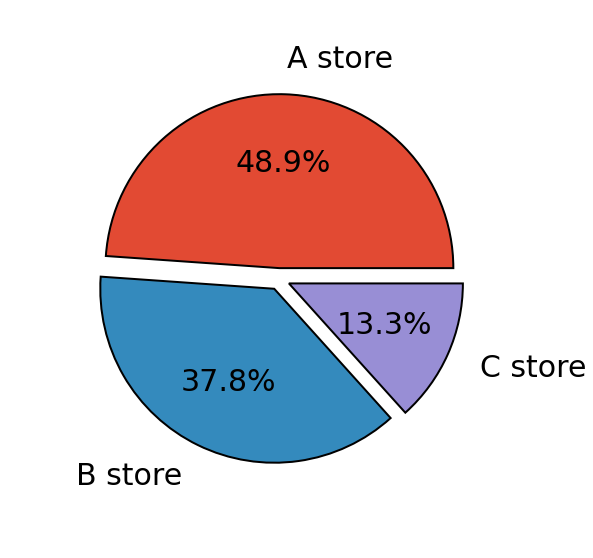

In [ ]:
sizes=[(22/(17+6+22))*100,(17/(17+6+22))*100,(6/(17+6+22))*100] # convert to the proportion
fig, axes = plt.subplots(1,1, figsize=(10,10))
wprops={'edgecolor':'black',
      'linewidth':2}
tprops = {'fontsize':30}
axes.pie(sizes,
        labels=labels,
        explode=(0.05,0.05,0.05),
        autopct='%1.1f%%',
        pctdistance=0.6,
        labeldistance=1.2,
        wedgeprops=wprops,
        textprops=tprops,
        radius=0.8,
        center=(0.4,0.4))
plt.show()

In [ ]:
data.describe

<bound method NDFrame.describe of         Store  Dept        Date  ...  IsHoliday_y  Type    Size
0           1     1  2010-02-05  ...        False     A  151315
1           1     2  2010-02-05  ...        False     A  151315
2           1     3  2010-02-05  ...        False     A  151315
3           1     4  2010-02-05  ...        False     A  151315
4           1     5  2010-02-05  ...        False     A  151315
...       ...   ...         ...  ...          ...   ...     ...
421565     45    93  2012-10-26  ...        False     B  118221
421566     45    94  2012-10-26  ...        False     B  118221
421567     45    95  2012-10-26  ...        False     B  118221
421568     45    97  2012-10-26  ...        False     B  118221
421569     45    98  2012-10-26  ...        False     B  118221

[421570 rows x 17 columns]>

In [ ]:
data.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday_x        bool
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
IsHoliday_y        bool
Type             object
Size              int64
dtype: object

In [ ]:
master_df=data

In [ ]:
master_df=master_df.fillna(0)
master_df.isna().sum()
master_df = master_df[master_df['Weekly_Sales'] >= 0]
# Cleaning holiday columns
master_df['IsHoliday'] = master_df['IsHoliday_x']
master_df = master_df.drop(columns=['IsHoliday_x', 'IsHoliday_y'])


In [ ]:
master_df

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday
0,1,1,2010-02-05,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
1,1,2,2010-02-05,50605.27,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
2,1,3,2010-02-05,13740.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
3,1,4,2010-02-05,39954.04,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
4,1,5,2010-02-05,32229.38,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False
421566,45,94,2012-10-26,5203.31,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False
421567,45,95,2012-10-26,56017.47,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False
421568,45,97,2012-10-26,6817.48,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False


In [ ]:
master_df['Date'] = pd.to_datetime(master_df['Date'], format='%Y-%m-%d')
master_df['Week_Number'] = master_df['Date'].dt.week
master_df['Quarter'] = master_df['Date'].dt.quarter
master_df['Month'] = master_df['Date'].dt.month.apply(lambda x: calendar.month_abbr[x])
master_df["Year"] = master_df["Date"].dt.year

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  


In [ ]:
master_df

,Store,Dept,Date,Weekly_Sales,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,IsHoliday,Week_Number,Quarter,Month,Year
0,1,1,2010-02-05,24924.50,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,5,1,Feb,2010
1,1,2,2010-02-05,50605.27,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,5,1,Feb,2010
2,1,3,2010-02-05,13740.12,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,5,1,Feb,2010
3,1,4,2010-02-05,39954.04,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,5,1,Feb,2010
4,1,5,2010-02-05,32229.38,42.31,2.572,0.00,0.00,0.0,0.00,0.00,211.096358,8.106,A,151315,False,5,1,Feb,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,43,4,Oct,2012
421566,45,94,2012-10-26,5203.31,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,43,4,Oct,2012
421567,45,95,2012-10-26,56017.47,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,43,4,Oct,2012
421568,45,97,2012-10-26,6817.48,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,B,118221,False,43,4,Oct,2012


In [ ]:
master_df.dtypes


Store                    int64
Dept                     int64
Date            datetime64[ns]
Weekly_Sales           float64
Temperature            float64
Fuel_Price             float64
MarkDown1              float64
MarkDown2              float64
MarkDown3              float64
MarkDown4              float64
MarkDown5              float64
CPI                    float64
Unemployment           float64
Type                    object
Size                     int64
IsHoliday                 bool
Week_Number              int64
Quarter                  int64
Month                   object
Year                     int64
dtype: object

In [ ]:
master_df.isna().sum()


Store           0
Dept            0
Date            0
Weekly_Sales    0
Temperature     0
Fuel_Price      0
MarkDown1       0
MarkDown2       0
MarkDown3       0
MarkDown4       0
MarkDown5       0
CPI             0
Unemployment    0
Type            0
Size            0
IsHoliday       0
Week_Number     0
Quarter         0
Month           0
Year            0
dtype: int64

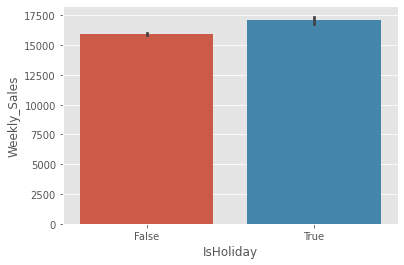

In [ ]:
holiday = master_df['Weekly_Sales'].loc[master_df['IsHoliday']== True] # Weekly Sales in Holidays
non_holiday = master_df['Weekly_Sales'].loc[master_df['IsHoliday']== False] #Weekly Sales in Non-holidays.
sns.barplot(x='IsHoliday', y='Weekly_Sales', data=master_df)

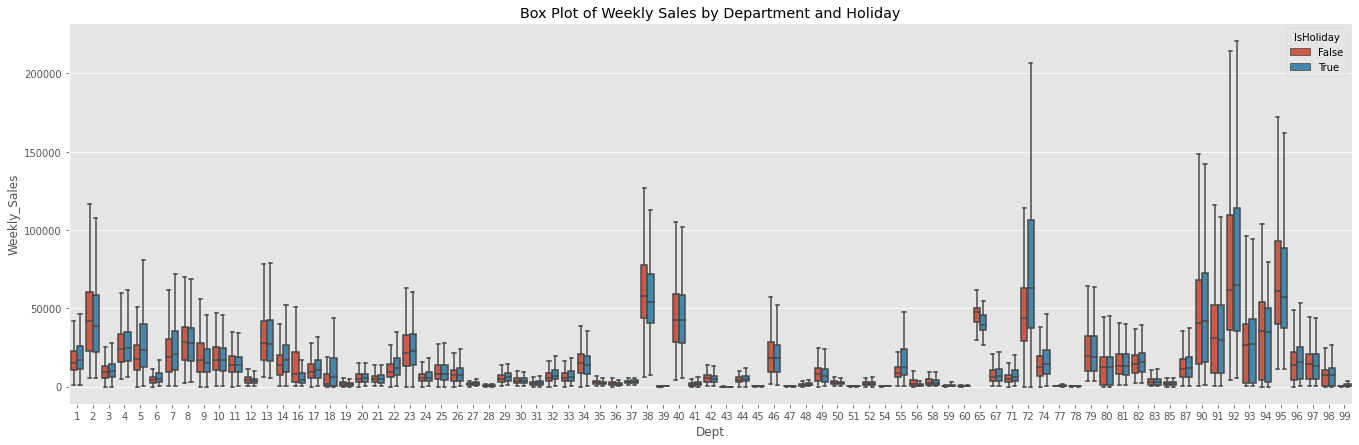

In [ ]:
data_11= pd.concat([master_df['Dept'], master_df['Weekly_Sales'], master_df['IsHoliday']], axis=1)
plt.figure(figsize=(23,7))
plt.title('Box Plot of Weekly Sales by Department and Holiday')
fig = sns.boxplot(x='Dept', y='Weekly_Sales',showfliers=False, data=data_11, hue="IsHoliday")

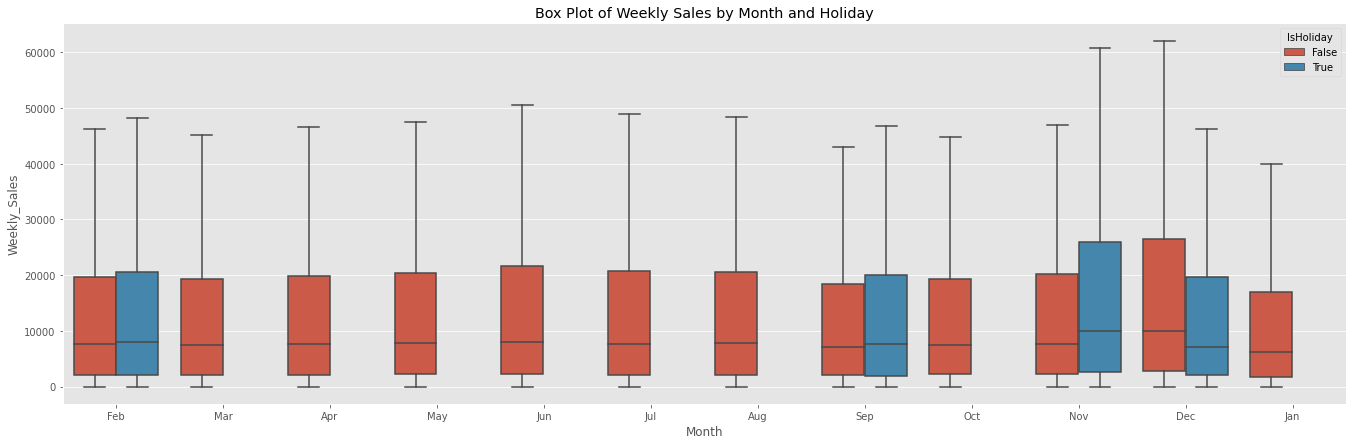

In [ ]:
data_12=pd.concat([master_df['Weekly_Sales'],master_df['Month'],master_df['IsHoliday']],axis=1)
plt.figure(figsize=(23,7))
plt.title('Box Plot of Weekly Sales by Month and Holiday')
fig=sns.boxplot(x='Month',y='Weekly_Sales',data=data_12,showfliers=False,hue='IsHoliday')

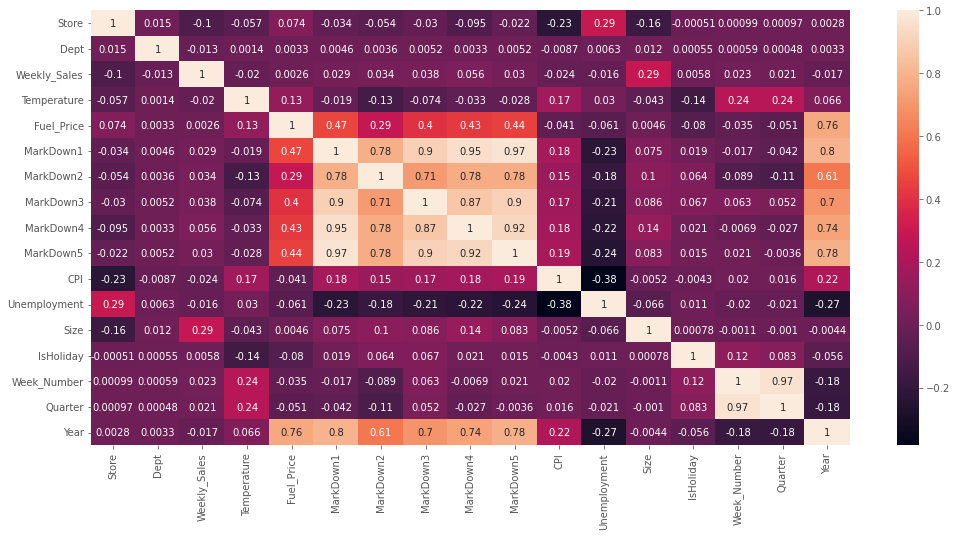

In [ ]:
plt.figure(figsize=(17,8))
sns.heatmap(master_df.corr('spearman'), annot = True)

In [ ]:
master_df2=master_df.copy()

# Pre-processing

In [ ]:
#Joining the train data with store and features data using inner join.
train = train.merge(features, on=['Store', 'Date'], how='inner').merge(stores, on=['Store'], how='inner')
print(train.shape)

(421570, 17)


In [ ]:
# Make one IsHoliday column instead of two.
train = train.drop(['IsHoliday_y'], axis=1)
train = train.rename(columns={'IsHoliday_x':'IsHoliday'})


In [ ]:
# Converting Date to datetime
train['Date'] = pd.to_datetime(train['Date'])

# Extract date features
train['Date_dayofweek'] =train['Date'].dt.dayofweek
train['Date_month'] =train['Date'].dt.month
train['Date_year'] =train['Date'].dt.year
train['Date_day'] =train['Date'].dt.day

In [ ]:
train_data1 = [train]

# Converting into numerical variables for the categorical variable 'Type' : A,B,C
type_mapping = {"A": 1, "B": 2, "C": 3}
for dataset in train_data1:
    dataset['Type'] = dataset['Type'].map(type_mapping)

# Converting into numerical variables for the categorical variable 'IsHoliday' : False,True
type_mapping = {False: 0, True: 1}
for dataset in train_data1:
    dataset['IsHoliday'] = dataset['IsHoliday'].map(type_mapping)

In [ ]:
# Kaggle has provided some dates to be allocated to special holidays. We have taken the special holidays into account and marked them as holidays.
train['Super_Bowl'] = np.where((train['Date'] == datetime(2010,2,10)) | (train['Date'] == datetime(2011,2,11)) |
                               (train['Date'] == datetime(2012,2,10)) | (train['Date'] == datetime(2013,2,8)), 1, 0)
train['Labor_day'] = np.where((train['Date'] == datetime(2010,9,10)) | (train['Date'] == datetime(2011,9,9)) |
                              (train['Date'] == datetime(2012,9,7)) | (train['Date'] == datetime(2013,9,6)), 1, 0)
train['Thanksgiving'] = np.where((train['Date']==datetime(2010, 11, 26)) | (train['Date']==datetime(2011, 11, 25)) |
                                 (train['Date']==datetime(2012, 11, 23)) | (train['Date']==datetime(2013, 11, 29)),1,0)
train['Christmas'] = np.where((train['Date']==datetime(2010, 12, 31)) | (train['Date']==datetime(2011, 12, 30)) |
                              (train['Date']==datetime(2012, 12, 28)) | (train['Date']==datetime(2013, 12, 27)),1,0)

In [ ]:
print('Train holidays:\n')
print ('Christmas Counts:\n', train.Christmas.value_counts(),'\n')
print ('Super Bowl Counts:\n', train.Super_Bowl.value_counts(),'\n')
print ('Thanksgiving Counts:\n', train.Thanksgiving.value_counts(),'\n')
print ('Labor Day Counts:\n', train.Labor_day.value_counts(),'\n')

Train holidays:

Christmas Counts:
 0    415624
1      5946
Name: Christmas, dtype: int64 

Super Bowl Counts:
 0    415631
1      5939
Name: Super_Bowl, dtype: int64 

Thanksgiving Counts:
 0    415611
1      5959
Name: Thanksgiving, dtype: int64 

Labor Day Counts:
 0    412709
1      8861
Name: Labor_day, dtype: int64 



In [ ]:
train

,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day,Super_Bowl,Labor_day,Thanksgiving,Christmas
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5,0,0,0,0
1,1,2,2010-02-05,50605.27,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5,0,0,0,0
2,1,3,2010-02-05,13740.12,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5,0,0,0,0
3,1,4,2010-02-05,39954.04,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5,0,0,0,0
4,1,5,2010-02-05,32229.38,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26,0,0,0,0
421566,45,94,2012-10-26,5203.31,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26,0,0,0,0
421567,45,95,2012-10-26,56017.47,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26,0,0,0,0
421568,45,97,2012-10-26,6817.48,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26,0,0,0,0


In [ ]:
# Since we already have the IsHoliday, these new column variables are redunadant, so we will drop them
dp = ['Super_Bowl','Labor_day','Thanksgiving','Christmas']
train.drop(dp, axis=1, inplace=True)

In [ ]:
train


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5
2,1,3,2010-02-05,13740.12,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5
3,1,4,2010-02-05,39954.04,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5
4,1,5,2010-02-05,32229.38,0,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,1,151315,4,2,2010,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
421565,45,93,2012-10-26,2487.80,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26
421566,45,94,2012-10-26,5203.31,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26
421567,45,95,2012-10-26,56017.47,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26
421568,45,97,2012-10-26,6817.48,0,58.85,3.882,4018.91,58.08,100.0,211.94,858.33,192.308899,8.667,2,118221,4,10,2012,26


In [ ]:
train = train.fillna(0)
#We are removing negative values just in case there is some error in the reporting of weekly sales
train = train[train['Weekly_Sales'] >= 0]
train.shape

(420285, 20)

In [ ]:
# We will also be removing irrelevant columns
features_drop=['Unemployment','CPI','MarkDown5']
train=train.drop(features_drop, axis=1)

print('Final train shape:', train.shape)
train.head(2)

Final train shape: (420285, 17)


,Store,Dept,Date,Weekly_Sales,IsHoliday,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,Type,Size,Date_dayofweek,Date_month,Date_year,Date_day
0,1,1,2010-02-05,24924.50,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5
1,1,2,2010-02-05,50605.27,0,42.31,2.572,0.0,0.0,0.0,0.0,1,151315,4,2,2010,5


In [ ]:
train = train.sort_values(by='Date', ascending=True) # Sorting the data in increasing order of Date and then splitting.
y = train['Weekly_Sales']
X = train.drop(['Weekly_Sales'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # Train:Test = 70:30 splitting.
X_train, X_cv, y_train, y_cv = train_test_split(X_train, y_train, test_size=0.3) #Train:CV = 70:30 splitting.

In [ ]:
# Remove Date column as it does not allow the models to fit on the data.
X_train = X_train.drop(['Date'], axis=1)
X_cv = X_cv.drop(['Date'], axis=1)
X_test = X_test.drop(['Date'], axis=1)

In [ ]:
# Final shapes.
print('Train:', X_train.shape, y_train.shape)
print('CV:', X_cv.shape, y_cv.shape)
print('Test', X_test.shape, y_test.shape)

Train: (205939, 15) (205939,)
CV: (88260, 15) (88260,)
Test (126086, 15) (126086,)


In [ ]:
"""Define Performance metric - Weighted Mean Absolute Error (WMAE)"""

def wmae_train(test, pred): # WMAE for train
  weights = X_train['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

def wmae_cv(test, pred): # WMAE for CV
  weights = X_cv['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

def wmae_test(test, pred): # WMAE for test
  weights = X_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

# ARIMA

In [ ]:
# It is necessary to have the date columns present in the dataset to be available in the datetime format as in ARIMA model it is required to see the sales values in date-wise fashion.
# Hence converting the string formatted Date into datetime format.
master_df.Date = pd.to_datetime(master_df.Date,format='%Y-%m-%d')
master_df.index = master_df.Date
master_df = master_df.drop('Date', axis=1)

In [ ]:
master_df = master_df.resample('MS').mean() # Resmapling the time series data with month starting first.

In [ ]:
# -Test splitting of time series data
train_data = master_df[:int(0.8*(len(master_df)))]
test_data = master_df[int(0.8*(len(master_df))):]

print('Train:', train_data.shape)
print('Test:', test_data.shape)

Train: (26, 17)
Test: (7, 17)


In [ ]:
# ARIMA takes univariate data.
train_data = train_data['Weekly_Sales']
test_data = test_data['Weekly_Sales']

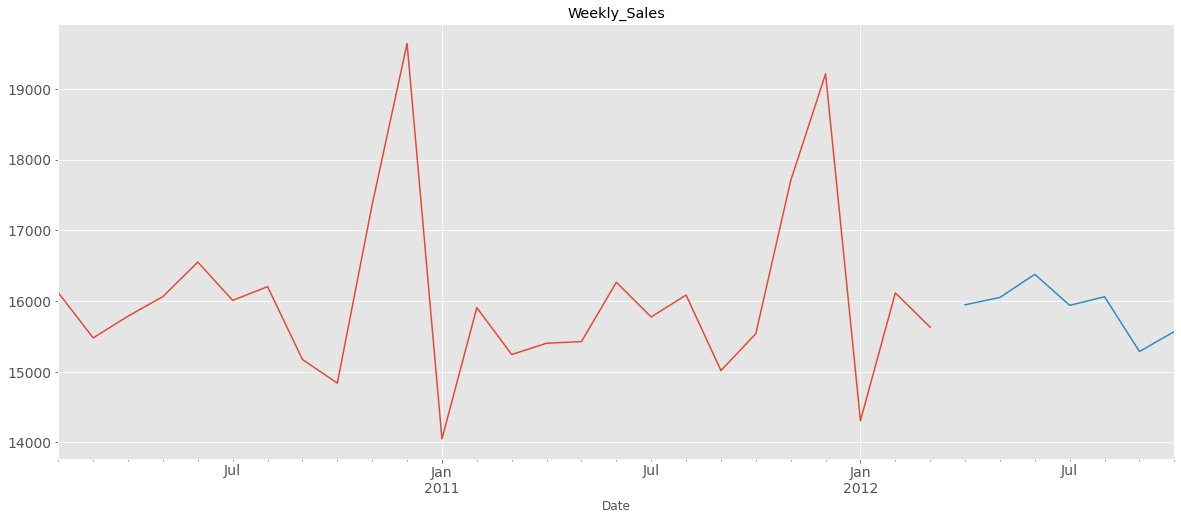

In [ ]:
# Plot of Weekly_Sales with respect to years in train and test.
train_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
test_data.plot(figsize=(20,8), title= 'Weekly_Sales', fontsize=14)
plt.show()

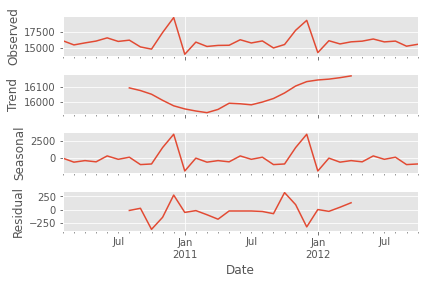

In [ ]:
#[Not part of ARIMA] Decomposition of time series data. It is necessary to see whether the trend, seasonality and residual are present in data or not.
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(master_df['Weekly_Sales'], model='additive')
result.plot()
plt.show()

Observation:

1) We can see that trend of weekly sales is decreasing till March and then increasing again.


2) We already know that data contains seasonality around holidays which is corraborated by the symmetric seasonal graph

In [ ]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
result = adfuller(master_df['Weekly_Sales'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))


ADF Statistic: -4.173916935101529
p-value: 0.0007291844915316654
Critical Values:
	1%: -3.769732625845229
	5%: -3.005425537190083
	10%: -2.6425009917355373


Observation:

1) Since the p-value is less than 0.05, we can reject the null hypothesis and declare the time series to be stationary.

2) Additionally, since the ADF Statistic is more negative than even the 1% critical value, we can further verify our decision of rejecting the null hypothesis.

In [ ]:
master_df3=master_df2.copy()

In [ ]:
# 2,0,1 ARIMA Model

model = ARIMA(master_df['Weekly_Sales'], order=(2,0,1)) #p,d,q
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:           Weekly_Sales   No. Observations:                   33
Model:                     ARMA(2, 1)   Log Likelihood                -273.765
Method:                       css-mle   S.D. of innovations            926.244
Date:                Tue, 21 Dec 2021   AIC                            557.531
Time:                        17:02:35   BIC                            565.013
Sample:                    02-01-2010   HQIC                           560.048
                         - 10-01-2012                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               1.603e+04     25.263    634.625      0.000     1.6e+04    1.61e+04
ar.L1.Weekly_Sales     0.6123      0.168      3.653      0.001       0.284       0.941
ar.L2.Weekly_Sales    -0.2458      0.165     -1.488      0.148      -0.570       0.078
ma.L1.Weekly_Sales    -1.0000      0.087    -11.477      0.000      -1.171      -0.829
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2453           -1.5865j            2.0169           -0.1441
AR.2            1.2453           +1.5865j            2.0169            0.1441
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

(Coeff here refer to the weight of the term)

Observation:

1) The coefficients are not that close to zero.

2) The p-value are less than 0.05 except AR2, so we can consider this model.

3) The AIC value is also the least with these model parameter (2,0,1)


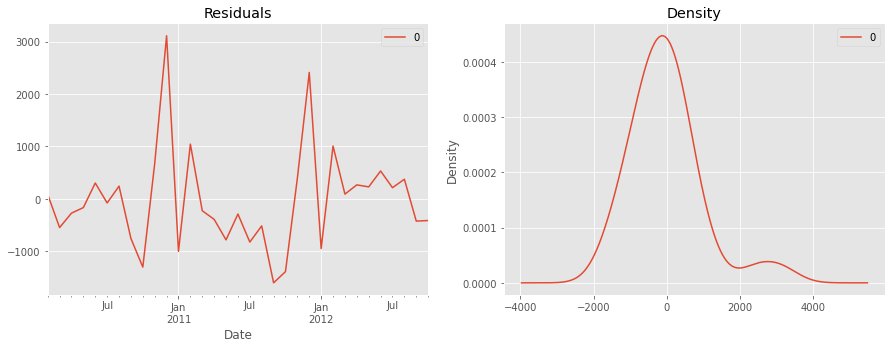

In [ ]:
residuals = pd.DataFrame(results.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(figsize=(15,5),title="Residuals", ax=ax[0])
residuals.plot(figsize=(15,5),kind='kde', title='Density', ax=ax[1])
plt.show()



Since the mean is almost at zero , theres is miniscule bias. But we can see some residual seasonality still present.

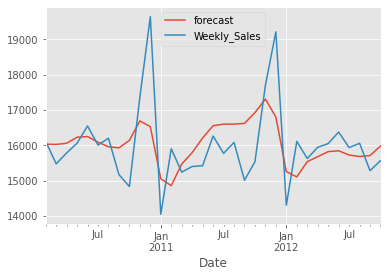

In [ ]:
results.plot_predict(dynamic=False)
plt.show()

<Figure size 1200x500 with 0 Axes>

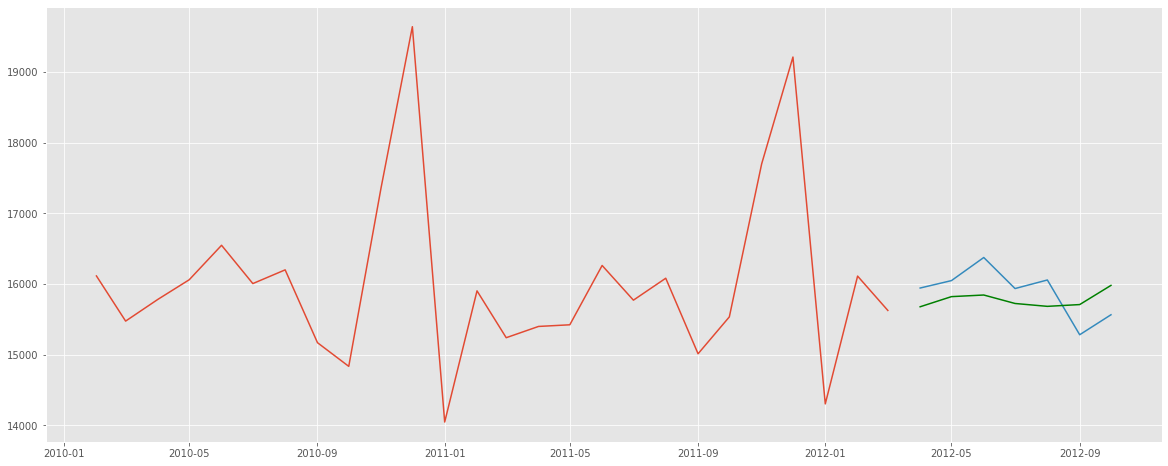

<Figure size 1200x500 with 0 Axes>

In [ ]:
fig = plt.figure(figsize=(20,8))
#num_points = len(clear_data['car.count'])
x = results.predict(start=("2012-4-01"), end=("2012-10-01"), dynamic=False)

plt.plot(train_data)
plt.plot(test_data)
plt.plot(x, color='g')
plt.figure(figsize=(12,5), dpi=100)

Although, its following the general trend of sales, there is a consntant deviation from the actual sales.

In [ ]:
print('Root Mean Squared Error (RMSE) of ARIMA: ', mean_squared_error(test_data, x)**(1/2))
print('Mean Absolute Deviation (MAD) of ARIMA: ', mean_absolute_error(test_data, x))

Root Mean Squared Error (RMSE) of ARIMA:  366.8292789099143
Mean Absolute Deviation (MAD) of ARIMA:  349.8805448241598


# Holt-Winter

In [ ]:
# Fitting the Holt-Winters method for Weekly Sales.
from statsmodels.tsa.api import ExponentialSmoothing
model2 = ExponentialSmoothing(train_data, seasonal_periods=7, trend='additive', seasonal='add').fit() #Taking additive (played around with others) trend and seasonality.
print (model2.summary())

                       ExponentialSmoothing Model Results                       
Dep. Variable:                    endog   No. Observations:                   26
Model:             ExponentialSmoothing   SSE                       48440203.665
Optimized:                         True   AIC                            397.381
Trend:                         Additive   BIC                            411.220
Seasonal:                      Additive   AICC                           427.715
Seasonal Periods:                     7   Date:                 Tue, 21 Dec 2021
Box-Cox:                          False   Time:                         17:02:36
Box-Cox Coeff.:                    None                                         
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.0526316                alpha                 True
smoothing_slope          

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


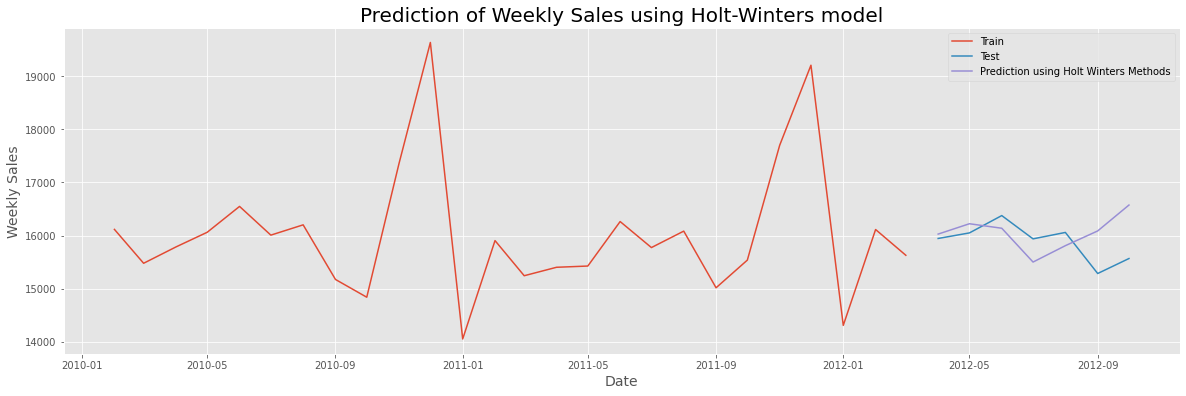

In [ ]:
pred = model2.forecast(len(test_data))
plt.figure(figsize=(20,6))
plt.title('Prediction of Weekly Sales using Holt-Winters model', fontsize=20)
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred, label='Prediction using Holt Winters Methods')
plt.legend(loc='best')
plt.xlabel('Date', fontsize=14)
plt.ylabel('Weekly Sales', fontsize=14)
plt.show()

In [ ]:
print('Root Mean Squared Error (RMSE) of Holt-Winters: ', mean_squared_error(test_data, pred)**(1/2))
print('Mean Absolute Deviation (MAD) of Holt-Winters: ', mean_absolute_error(test_data, pred))

Root Mean Squared Error (RMSE) of Holt-Winters:  535.8987825539803
Mean Absolute Deviation (MAD) of Holt-Winters:  427.65183779828374



# Linear Regression

In [ ]:
Dt = train['Weekly_Sales'] #DT-Dependant(y)
Idt = train.drop(['Weekly_Sales'], axis=1) #Idt-Independant(x)

Idt_train, Idt_test, Dt_train, Dt_test = train_test_split(Idt, Dt, test_size=0.3) # Train:Test = 70:30 splitting.

# Remove Date column as it does not allow the models to fit on the data.
Idt_train = Idt_train.drop(['Date'], axis=1)
Idt_test = Idt_test.drop(['Date'], axis=1)


def wmae_train(test, pred): # WMAE for train
  weights = Idt_train['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error


def wmae_test(test, pred): # WMAE for test
  weights = Idt_test['IsHoliday'].apply(lambda is_holiday:5 if is_holiday else 1)
  error = np.sum(weights * np.abs(test - pred), axis=0) / np.sum(weights)
  return error

In [ ]:
#https://realpython.com/linear-regression-in-python/
model_linear_reg = LinearRegression()
model_linear_reg.fit(Idt_train,Dt_train) # Fit the model.

LinearRegression()

In [ ]:
model_linear_reg=model_linear_reg.fit(Idt_train,Dt_train)

In [ ]:
r_sq = model_linear_reg.score(Idt_train, Dt_train)
print('coefficient of determination:', r_sq)

coefficient of determination: 0.08698787973381727


Very low amount of variation in 𝑦 can be explained by the dependence on 𝐱 using this particular regression model as R is very low

In [ ]:
print('intercept:', model_linear_reg.intercept_)
print('slope:', model_linear_reg.coef_)

intercept: 1220063.7221362854
slope: [-8.50348995e+01  1.13474250e+02  1.44242719e+02  5.73921387e+00
  6.16048230e+02  3.46009580e-02  1.37166840e-02  1.14381154e-01
  1.39959740e-02  1.81832374e+03  1.02764553e-01  6.82121026e-13
  1.42044291e+02 -6.10322965e+02 -1.81405841e+01]


Intercept is y when x=0 and slopes are calculated for each independant variable. Hence 15 values.

In [ ]:
y_pred = model_linear_reg.predict(Idt_test) # Predict test data.

In [ ]:
print('Weighted Mean Absolute Error (WMAE) for Linear Regression:', wmae_test(Dt_test, y_pred)) # Calculate WMAE score.
print('Mean Squared Error (RMSE) of Linear Regression:', mean_squared_error(Dt_test, y_pred)**(1/2))


Weighted Mean Absolute Error (WMAE) for Linear Regression: 14832.419132111836
Mean Squared Error (RMSE) of Linear Regression: 21737.553646910354


# Decision Tree Regression

In [ ]:
# Define the list of errors and list of hyper parameters.
error_cv_dt = []
error_train_dt = []
max_depth = [1,5,10,15,20,25,30,35]
min_samples_leaf = [1,2,3,4,5,6,7,8]
dt_hyperparams = []

In [ ]:
for i in max_depth: # Loop over max_depth.
    for j in min_samples_leaf: # Loop over min_samples_leaf.
        dt = DecisionTreeRegressor(max_depth=i, min_samples_leaf=j) # Apply Decision Tree Regressor.
        Z=dt.fit(X_train, y_train) # Fit the model.
        y_pred_cv_dt = dt.predict(X_cv) # Predict CV data.
        y_pred_train_dt = dt.predict(X_train) # Predict Train data.
        error_cv_dt.append(wmae_cv(y_cv, y_pred_cv_dt)) # Calculate CV error.
        error_train_dt.append(wmae_train(y_train, y_pred_train_dt)) # Calculate Train error.
        dt_hyperparams.append({'depth':i, 'leaf':j}) # Get the list of hyper parameters.

In [ ]:
dt_dataframe = pd.DataFrame(dt_hyperparams)
dt_dataframe['train error'] = error_train_dt
dt_dataframe['cv error'] = error_cv_dt
dt_dataframe.sort_values(by=['cv error'], ascending=True)

,depth,leaf,train error,cv error
53,30,6,694.509292,2111.017225
45,25,6,696.322391,2111.672677
61,35,6,694.470128,2111.910216
54,30,7,737.148524,2113.004035
62,35,7,737.143660,2113.391986
...,...,...,...,...
3,1,4,6956.412725,14271.765980
5,1,6,6956.412725,14271.765980
0,1,1,6956.412725,14271.765980
2,1,3,6956.412725,14271.765980


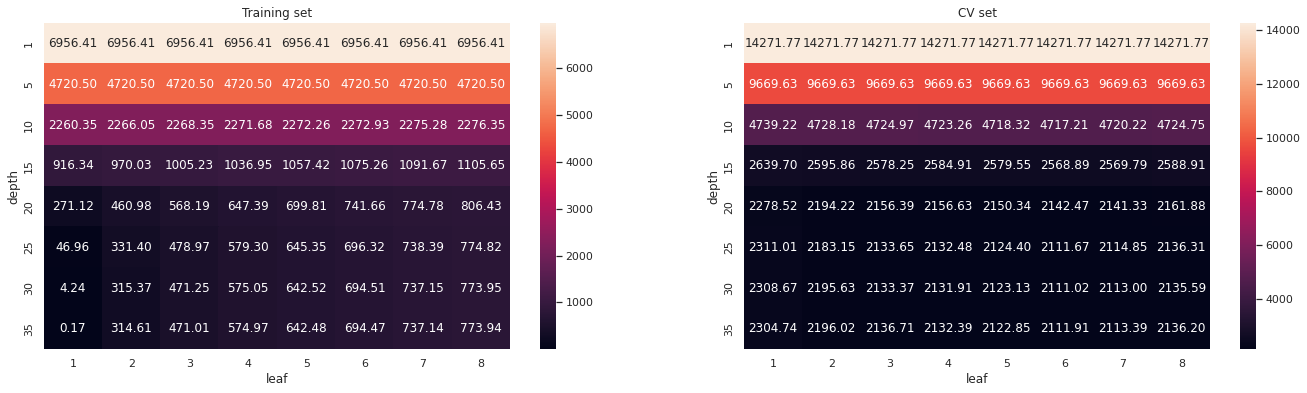

In [ ]:
sns.set(font_scale=1,)
train_dt = pd.pivot_table(dt_dataframe ,'train error','depth','leaf') # Pivot table for train.
cv_dt = pd.pivot_table(dt_dataframe , 'cv error','depth','leaf') # Pivot table for CV.
fig, ax = plt.subplots(1,2, figsize=(23,6))
sns.heatmap(train_dt, annot=True, fmt='.2f', ax=ax[0]) # Train heatmap.
sns.heatmap(cv_dt, annot=True, fmt='.2f', ax=ax[1]) # CV heatmap.
ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

After much trial and error:
We can observe that training errors and CV errors are least for minimum sample leaf of 6 and almost similar from depth 25 to 35. Thus to prevent over-fitting, we use 25 as the depth of the tree.

In [ ]:
model_dt = DecisionTreeRegressor(max_depth=25, min_samples_leaf=6).fit(X_train, y_train) # Fit the model with best hyper parameter values.


In [ ]:
y_pred = model_dt.predict(X_test) # Predict the test data.
model_dt

DecisionTreeRegressor(max_depth=25, min_samples_leaf=6)

In [ ]:
from sklearn.metrics import r2_score
r2_score(y_test,y_pred)

0.9471676866743453

In [ ]:
# import export_graphviz
from sklearn.tree import export_graphviz
from graphviz import Source
from sklearn import tree



In [ ]:
#graph = Source( tree.export_graphviz(model_dt, out_file=None, feature_names=X_train.columns))
#png_bytes = graph.pipe(format='png')
#with open('dtree_pipe.png','wb') as f:
 #   f.write(png_bytes)

#from IPython.display import Image
#Image(png_bytes)

In [ ]:
print('Weighted Mean Absolute Error (WMAE) for Decision Tree Regression:', wmae_test(y_test, y_pred))
print('Mean Squared Error (RMSE) of Decision Tree Regression: ', mean_squared_error(y_test, y_pred)**(1/2))

Weighted Mean Absolute Error (WMAE) for Decision Tree Regression: 667.9459508602502
Mean Squared Error (RMSE) of Decision Tree Regression:  5248.3108813751805


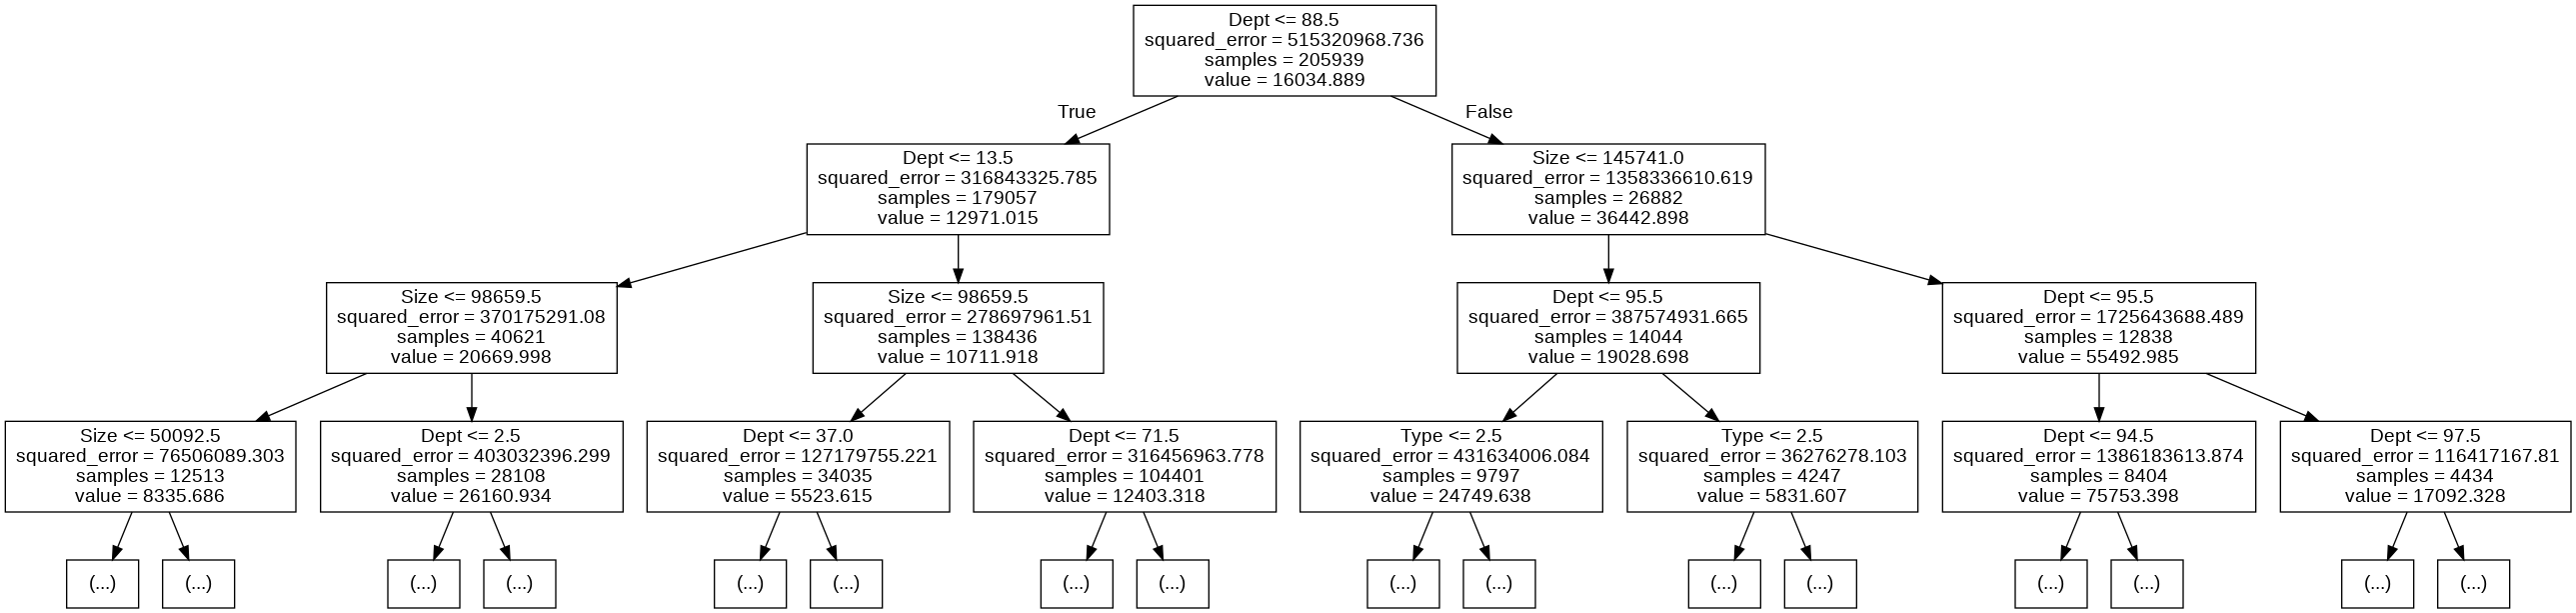

In [ ]:
graph = Source( tree.export_graphviz(model_dt, out_file=None, feature_names=X_train.columns, max_depth=3))
png_bytes = graph.pipe(format='png')
with open('decisiontree_pipe.png','wb') as f:
    f.write(png_bytes)

from IPython.display import Image
Image(png_bytes)

# Random Forest Regression

In [ ]:
error_cv_rf = []
error_train_rf = []
max_depth = [1,5,10,15,20,25,30,35]
n_estimators = [10,20,30,40,50,60,70,80,90,100]
rf_hyperparams = []

In [ ]:
for i in max_depth: # Loop over max_depth.
    for j in n_estimators: # Loop over n_estimators.
        rf = RandomForestRegressor(max_depth=i, n_estimators=j) # Apply Random Forest Regressor.
        rf.fit(X_train, y_train) # Fit the model.
        y_pred_cv_rf = rf.predict(X_cv) # Predict CV data.
        y_pred_train_rf = rf.predict(X_train) # Predict Train data.
        error_cv_rf.append(wmae_cv(y_cv, y_pred_cv_rf)) # Get CV error.
        error_train_rf.append(wmae_train(y_train, y_pred_train_rf)) # Get Train error.
        rf_hyperparams.append({'Maximum Depth':i, 'No. of Estimators':j}) # Get list of hyper parameter values.

In [ ]:
rf_dataframe = pd.DataFrame(rf_hyperparams)
rf_dataframe['Train Error']=error_train_rf
rf_dataframe['CV Error']=error_cv_rf
rf_dataframe.sort_values(by=['CV Error'], ascending=True)

,Maximum Depth,No. of Estimators,Train Error,CV Error
69,30,100,317.702938,1743.538859
67,30,80,320.034726,1743.610685
76,35,70,320.460976,1745.501598
59,25,100,330.899830,1746.757885
57,25,80,330.909099,1749.604121
...,...,...,...,...
6,1,70,6957.540583,14274.012949
2,1,30,6957.697817,14274.498986
0,1,10,6957.974678,14275.119814
5,1,60,6958.799566,14276.681755


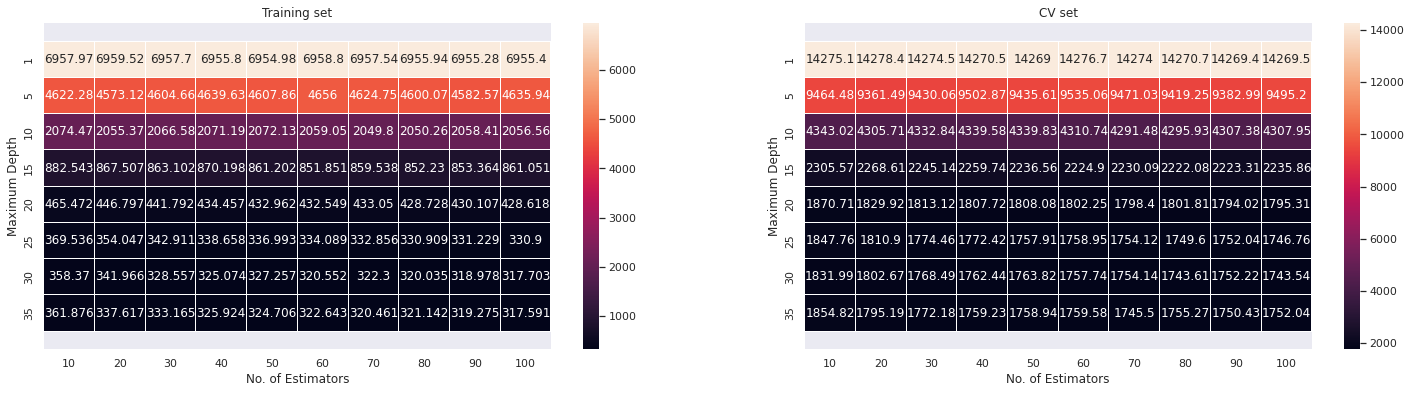

In [ ]:

sns.set(font_scale=1.0)
train_rf = pd.pivot_table(rf_dataframe,'Train Error','Maximum Depth','No. of Estimators') # Pivot table of Train data.
cv_rf = pd.pivot_table(rf_dataframe, 'CV Error','Maximum Depth','No. of Estimators') # Pivot table of CV data.
fig, ax = plt.subplots(1,2, figsize=(25,6))
ax_train = sns.heatmap(train_rf, annot=True, fmt='2g', ax=ax[0], linewidths=0.01)
ax_cv = sns.heatmap(cv_rf, annot=True, fmt='4g', ax=ax[1], linewidths=0.01)

bottom_train, top_train = ax_train.get_ylim()
ax_train.set_ylim(bottom_train + 0.5, top_train - 0.5)

bottom_cv, top_cv = ax_cv.get_ylim()
ax_cv.set_ylim(bottom_cv + 0.5, top_cv - 0.5)

ax[0].set_title('Training set')
ax[1].set_title('CV set')
plt.show()

In [ ]:
model_rf = RandomForestRegressor(max_depth= 35, n_estimators=90).fit(X_train, y_train) # Fit the model with best hyper parameter values.


In [ ]:
y_pred = model_rf.predict(X_test) # Predict the test data.

In [ ]:
r2_score(y_test,y_pred)

0.9637383803840838

In [ ]:
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.
print('Mean Squared Error (RMSE) of Holt-Winters: ', mean_squared_error(y_test, y_pred)**(1/2))

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 550.381351984281
Mean Squared Error (RMSE) of Holt-Winters:  4348.038067197338


In [ ]:

model_rf = RandomForestRegressor(max_depth= 35, n_estimators=100).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 552.1952587757768


In [ ]:

model_rf = RandomForestRegressor(max_depth= 30, n_estimators=90).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 552.0263556183296


In [ ]:

model_rf = RandomForestRegressor(max_depth= 25, n_estimators=90).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 552.6493836503349


In [ ]:

model_rf = RandomForestRegressor(max_depth= 25, n_estimators=100).fit(X_train, y_train) # Fit the model with best hyper parameter values.
y_pred = model_rf.predict(X_test) # Predict the test data.
print('Weighted Mean Absolute Error (WMAE) for Random Forest Regression:', wmae_test(y_test, y_pred)) # Get WMAE score.

Weighted Mean Absolute Error (WMAE) for Random Forest Regression: 550.1995602444185
